# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from scipy import stats
import mne
import os


# Data Preparation

In [2]:

old = "old_results_all.csv"
young = "young_results_all.csv"
old_df = pd.read_csv(old)
young_df = pd.read_csv(young)

combined_df = pd.concat([old_df, young_df], ignore_index=True)

old_male_id = old_df[old_df['group'].str.contains('Male')]['subject_id'].unique()
old_female_id = old_df[old_df['group'].str.contains('Female')]['subject_id'].unique()

print(f"Number of old male participants: {len(old_male_id)}")
print(f"Number of old female participants: {len(old_female_id)}")




young_male_id = combined_df[(combined_df['age_group'] == 'young') & (combined_df['group'].str.contains('Male'))]['subject_id'].unique()
print(f"Number of young male participants: {len(young_male_id)}")

young_female_id = combined_df[(combined_df['age_group'] == 'young') & (combined_df['group'].str.contains('Female'))]['subject_id'].unique()
print(f"Number of young female participants: {len(young_female_id)}")

young_male_subjects = np.random.choice(young_male_id, size=18, replace=False)
young_female_subjects = np.random.choice(young_female_id, size=11, replace=False)

print(f"Old male subjects: {old_male_id}")
print(f"Old female subjects: {old_female_id}")
print(f"Young male subjects: {young_male_subjects}")
print(f"Young female subjects: {young_female_subjects}")

selected_young_subjects = np.concatenate([young_male_subjects, young_female_subjects])

print(f"Selected young subjects: {selected_young_subjects}")


# Create a new dataframe with the selected subjects both old and young
selected_subjects = np.concatenate([old_male_id, old_female_id, selected_young_subjects])
print("-" * 100)
print(f"Selected subjects: {selected_subjects}")
print(len(selected_subjects))

# Turn this into a dataframe
selected_subjects_df = pd.DataFrame(selected_subjects, columns=['subject_id'])
new_df = combined_df[combined_df['subject_id'].isin(selected_subjects)]

Number of old male participants: 19
Number of old female participants: 10
Number of young male participants: 28
Number of young female participants: 11
Old male subjects: ['sub-010290' 'sub-010276' 'sub-010081' 'sub-010246' 'sub-010089'
 'sub-010257' 'sub-010289' 'sub-010088' 'sub-010268' 'sub-010272'
 'sub-010286' 'sub-010092' 'sub-010284' 'sub-010283' 'sub-010251'
 'sub-010267' 'sub-010085' 'sub-010245' 'sub-010243']
Old female subjects: ['sub-010258' 'sub-010242' 'sub-010291' 'sub-010086' 'sub-010090'
 'sub-010250' 'sub-010249' 'sub-010247' 'sub-010277' 'sub-010244']
Young male subjects: ['sub-010241' 'sub-010195' 'sub-010319' 'sub-010227' 'sub-010252'
 'sub-010263' 'sub-010067' 'sub-010310' 'sub-010304' 'sub-010292'
 'sub-010298' 'sub-010300' 'sub-010294' 'sub-010260' 'sub-010053'
 'sub-010265' 'sub-010261' 'sub-010317']
Young female subjects: ['sub-010266' 'sub-010064' 'sub-010166' 'sub-010157' 'sub-010155'
 'sub-010164' 'sub-010075' 'sub-010165' 'sub-010270' 'sub-010083'
 'sub-01

## Normalize the power


The following code implements a subject-specific normalization approach:

1. **Create a working copy** of the original dataframe to preserve raw data
2. **Iterate through each subject** to handle individual differences
3. **Process each condition-band combination** separately for proper normalization context
4. **Calculate normalization factor** as the sum of power values across all regions
5. **Normalize region-specific power** by dividing by the total power

This approach ensures that power comparisons between regions account for individual 
differences in overall signal strength while maintaining the relative distribution 
across brain regions.

In [4]:
new_df_normalized = new_df.copy()
for subject in new_df['subject_id'].unique():
    subjectdf = new_df[new_df['subject_id'] == subject]

    for condition in subjectdf['condition'].unique():
        for band in subjectdf['band'].unique():
            normalizs = subjectdf[(subjectdf['condition'] == condition) & (subjectdf['band'] == band)]['power'].sum()
            for region in subjectdf['region'].unique():
                power = subjectdf[(subjectdf['condition'] == condition) & (subjectdf['band'] == band) & (subjectdf['region'] == region)]['power'].values[0]
                new_df_normalized.loc[(new_df_normalized['subject_id'] == subject) & (new_df_normalized['condition'] == condition) & (new_df_normalized['band'] == band) & (new_df_normalized['region'] == region),'normalized_power'] = power / normalizs

new_df_normalized


,subject_id,group,age_group,condition,region,band,power,normalized_power
0,sub-010290,Male_60-65,older,EC,occipital,alpha,4.101482e+29,0.446435
1,sub-010290,Male_60-65,older,EC,occipital,beta,2.158499e+29,0.336308
2,sub-010290,Male_60-65,older,EC,occipital,theta,8.683016e+28,0.331787
3,sub-010290,Male_60-65,older,EC,parietal,alpha,2.020458e+29,0.219921
4,sub-010290,Male_60-65,older,EC,parietal,beta,1.411419e+29,0.219908
...,...,...,...,...,...,...,...,...
1627,sub-010157,Female_20-25,young,EO,temporal,beta,6.576708e+28,0.213389
1628,sub-010157,Female_20-25,young,EO,temporal,theta,5.053774e+28,0.211244
1629,sub-010157,Female_20-25,young,EO,frontal,alpha,4.295043e+28,0.129743
1630,sub-010157,Female_20-25,young,EO,frontal,beta,5.571163e+28,0.180763


# Plots

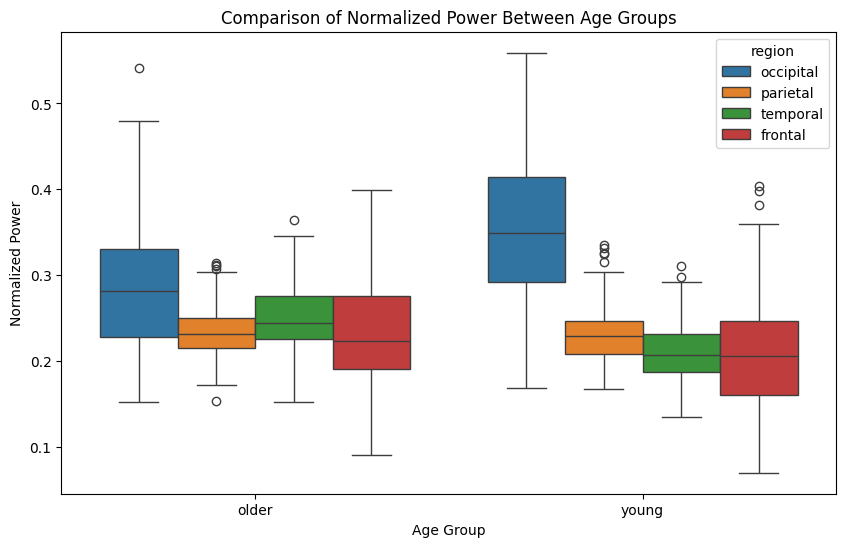

In [5]:

plt.figure(figsize=(10, 6))
sns.boxplot(x='age_group', y='normalized_power', data=new_df_normalized, hue='region')

plt.title('Comparison of Normalized Power Between Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Normalized Power')
plt.show()

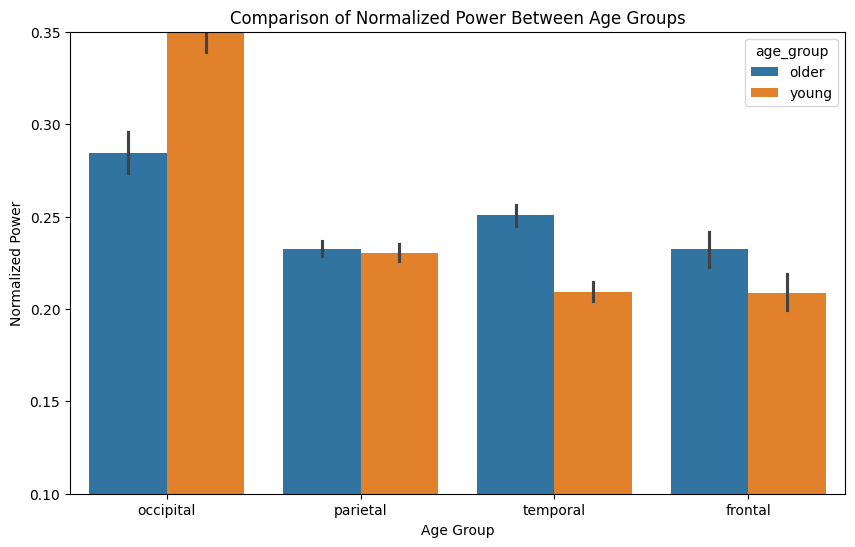

In [6]:
plt.figure(figsize=(10, 6))
sns.barplot(x='region', y='normalized_power', data=new_df_normalized, hue='age_group')

plt.title('Comparison of Normalized Power Between Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Normalized Power')
plt.ylim([0.10,0.35])
plt.show()

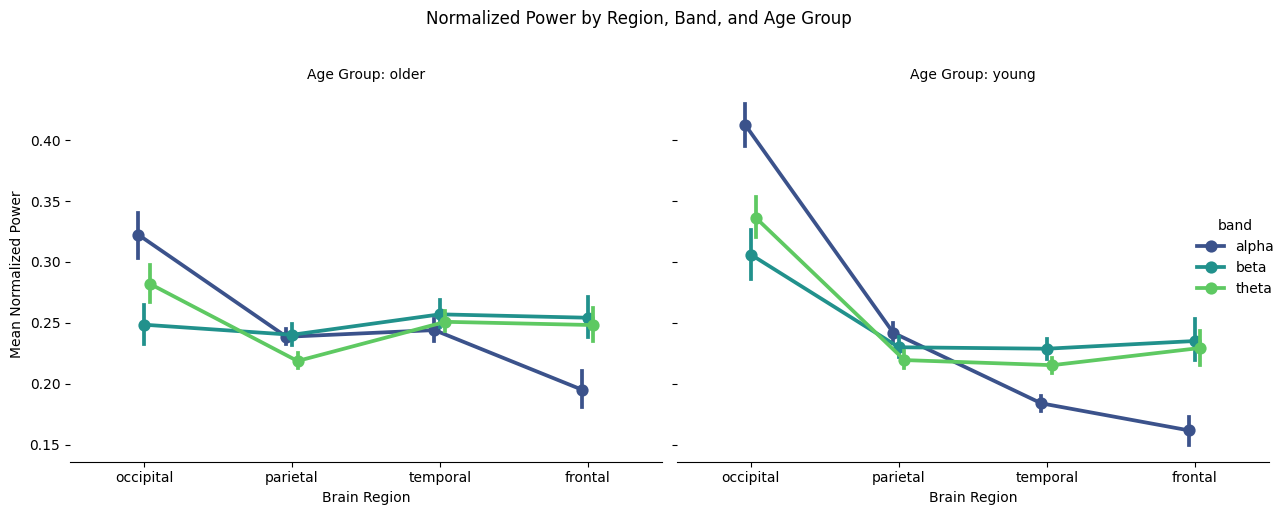

In [ ]:

# Create the point plot using the correct DataFrame
g = sns.catplot(
    data=new_df_normalized,  # <<< Use new_df_normalized here
    x='region',
    y='normalized_power',
    hue='band',
    col='age_group',
    kind='point',
    dodge=True,
    errorbar=('ci', 95),
    palette='viridis',
    height=5,
    aspect=1.2
)

# Improve readability
g.set_axis_labels("Brain Region", "Mean Normalized Power")
g.set_titles("Age Group: {col_name}")
g.despine(left=True)
plt.suptitle('Normalized Power by Region, Band, and Age Group', y=1.02)
plt.tight_layout()
plt.show()
